In [22]:
import numpy as np
import scipy 
import itertools as it

from pyiga import bspline, vform, geometry, vis, solvers, utils, topology

In [128]:
def Heatsquare(B1=1, B2=1, deg=1, N=3):
    h1, h2 = 1/B1, 1/B2
    geos= [geometry.unit_square().scale((h1,h2)).translate((j*h1,i*h2)) for i,j in it.product(range(B2),range(B1))]
    kvs = B1*B2 *[2* (bspline.make_knots(deg,0,1,N),)]
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches, domains={i:{i} for i in range(B1*B2)})
    M.set_boundary_id({'D':{(B1*B2 - i - 1,1) for i in range(B1)},'N0':{(B1*j,2) for j in range(B2)}|{(B1*j+B2+1,3) for j in range(B2)},'N1':{(i,0) for i in range(B1)}})
    return M

In [129]:
M = Heatsquare(6,4)

In [130]:
M.outer_boundaries

{'D': {(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)},
 'N0': {(0, 2), (5, 3), (6, 2), (11, 3), (12, 2), (17, 3), (18, 2), (23, 3)},
 'N1': {(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0)}}

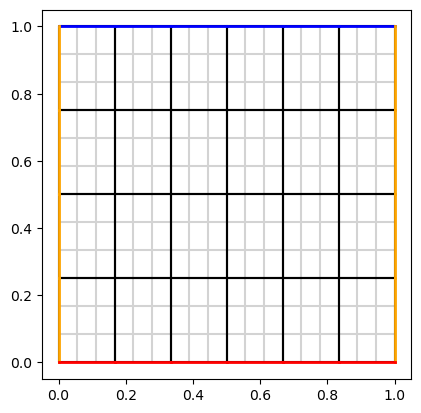

In [136]:
M.draw(knots=1,patch_idx=0, bcolor={'D':'blue','N0':'orange','N1':'red'},bwidth=2)

In [67]:
B1, B2 = 3,4

In [70]:
{B1*B2 - i - 1 for i in range(B1)}

{9, 10, 11}

In [66]:
M.domains

{0: {0},
 1: {1},
 2: {2},
 3: {3},
 4: {4},
 5: {5},
 6: {6},
 7: {7},
 8: {8},
 9: {9},
 10: {10},
 11: {11},
 12: {12},
 13: {13},
 14: {14},
 15: {15},
 16: {16},
 17: {17},
 18: {18},
 19: {19},
 20: {20},
 21: {21},
 22: {22},
 23: {23},
 24: {24},
 25: {25},
 26: {26},
 27: {27},
 28: {28},
 29: {29},
 30: {30},
 31: {31},
 32: {32},
 33: {33},
 34: {34},
 35: {35}}

In [37]:
4*[2*(bspline.make_knots(1,0,1,3),)]

[(KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1),
  KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1)),
 (KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1),
  KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1)),
 (KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1),
  KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1)),
 (KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1),
  KnotVector(array([0.        , 0.        , 0.33333333, 0.66666667, 1.        ,
         1.        ]), 1))]

In [11]:
bspline.make_knots()

TypeError: make_knots() missing 4 required positional arguments: 'p', 'a', 'b', and 'n'

In [21]:
[x for xs in xss for x in xs]

NameError: name 'xss' is not defined

In [25]:
list(it.product(range(3),range(4)))

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3)]